In [ ]:
#| hide
!pip install -Uqq nixtla
!pip install pandas_market_calendars

In [2]:
#| hide 
from nixtla.utils import in_colab

In [3]:
#| hide 
IN_COLAB = in_colab()

In [4]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Custom frequencies 

When working with time series data, the frequency of the timestamps is a crucial factor that can significantly impact the forecasting results. Regular frequencies like daily, weekly, or monthly are straightforward to handle. However, some specific frquencies can be challenging to work with.

Our forecast method is designed to handle these types of time series data, provided that the frequency of the series is specified correctly. In this tutorial, we will show how to work with custom frequencies, such as the days the U.S. stock market is open.

## 1. Import packages 
First, we import the required packages and initialize the Nixtla client

In [5]:
import pandas as pd
import pandas_market_calendars as mcal
from nixtla import NixtlaClient

In [6]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [7]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

In this example, we will use the daily stock prices of Palantir Technologies (PLTR) from 2020 to 2023. The dataset includes data up to 2023-09-22, but for this tutorial, we will exclude any data before 2023-08-28. This allows us to show how a custom frequency can handle days when the stock market is closed, such as Labor Day in the U.S. 

In [8]:

pltr_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/openbb/pltr.csv', parse_dates=['date'])
pltr_df = pltr_df.query('date < "2023-08-28"')
pltr_df.head()

,date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
0,2020-09-30,10.00,11.41,9.11,9.50,9.50,338584400,0.0,0.0
1,2020-10-01,9.69,10.10,9.23,9.46,9.46,124297600,0.0,0.0
2,2020-10-02,9.06,9.28,8.94,9.20,9.20,55018300,0.0,0.0
3,2020-10-05,9.43,9.49,8.92,9.03,9.03,36316900,0.0,0.0
4,2020-10-06,9.04,10.18,8.90,9.90,9.90,90864000,0.0,0.0


We will forecast the close price, so we will exclude the other columns from the dataset.

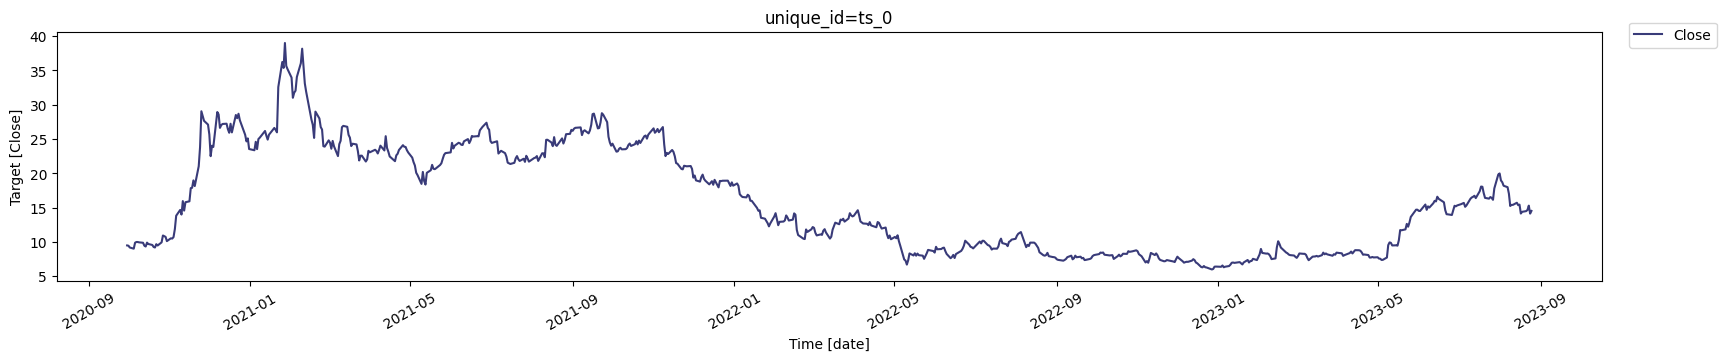

In [9]:
pltr_df = pltr_df[['date', 'Close']]

nixtla_client.plot(pltr_df, time_col = "date", target_col = "Close")

## 3. Define a custom frequency 

To define a custom frequency, we will first extract and sort the dates from the input data, ensuring they are in the correct datetime format. Next, we will use the [`pandas_market_calendars package`](https://pypi.org/project/pandas-market-calendars/), specifically the `get_calendar` method, to obtain the New York Stock Exchange (NYSE) calendar. Using this calendar, we can create a custom frequency that includes only the days the stock market is open.

In [10]:
dates = pd.DatetimeIndex(sorted(pltr_df['date'].unique())) # sort all dates in the dataset

nyse = mcal.get_calendar('NYSE') # New Yor Stock Exchange calendar 

Note that the days the stock market is open need to include all the dates in the input data plus the forecast horizon. In this example, we will forecast 14 days ahead, so we need to make sure our trading days include the last date in the input data as well as the next 14 valid trading days.

To avoid dealing with holidays or weekends during the forecast horizon, we will specify an end date well beyond the forecast horizon. For this example, we will use January 1, 2024, as a safe cutoff.

In [11]:
trading_days = nyse.valid_days(start_date=dates.min(), end_date="2024-01-01").tz_localize(None)

Now, with the list of trading days, we can identify the days the stock market is closed. These are all weekdays (Monday to Friday) within the range that are not trading days. Using this information, we can define a custom frequency that skips the stock market's closed days.

In [12]:
all_weekdays = pd.date_range(start=dates.min(), end="2024-01-01", freq='B')

closed_days = all_weekdays.difference(trading_days)

custom_bday = pd.offsets.CustomBusinessDay(holidays=closed_days)

## 4. Forecast with a custom frequency

With the custom frequency defined, we can now use the `forecast` method, specifying the `custom_bday` frequency in the `freq` argument. This will make the forecast respect the trading schedule of the stock market.

In [13]:
fcst_pltr_df = nixtla_client.forecast(
    df=pltr_df, 
    h=14, 
    freq=custom_bday,
    time_col='date', 
    target_col='Close',
    level=[80, 95]
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


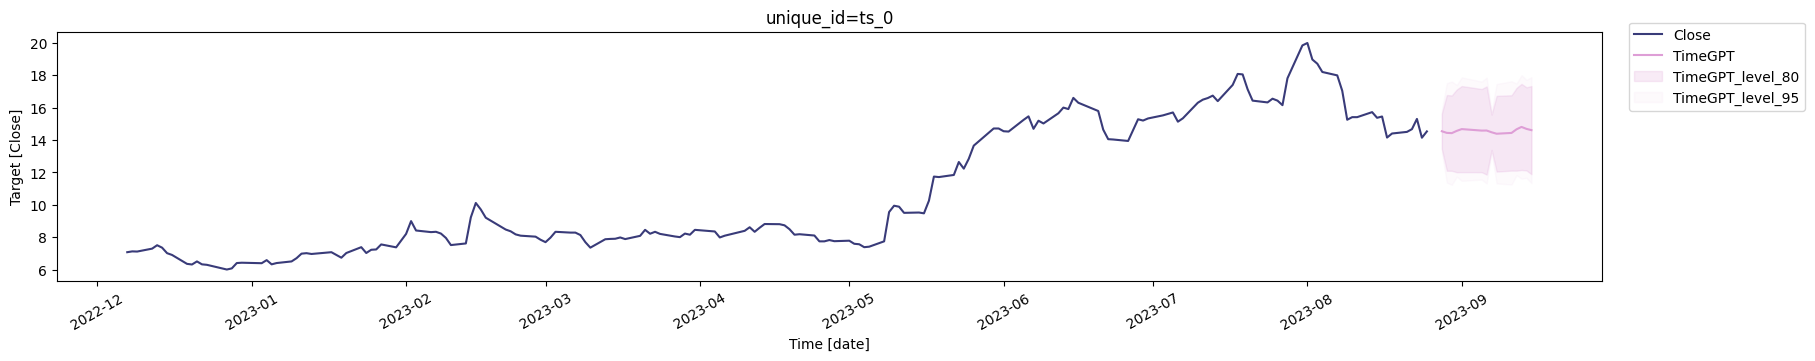

In [14]:
nixtla_client.plot(pltr_df, fcst_pltr_df, time_col = "date", target_col = "Close", level=[80, 95], max_insample_length = 180)

In [15]:
fcst_pltr_df.head(7)

,date,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-95,TimeGPT-lo-80,TimeGPT-lo-95
0,2023-08-28,14.539908,15.628469,15.825957,13.451347,13.253860
1,2023-08-29,14.439324,16.777246,17.508512,12.101404,11.370136
2,2023-08-30,14.423326,16.749462,17.612267,12.097193,11.234386
3,2023-08-31,14.562670,17.115122,17.394060,12.010217,11.731278
4,2023-09-01,14.672756,17.330622,17.867441,12.014891,11.478071
5,2023-09-05,14.579653,17.147617,17.604850,12.011689,11.554455
6,2023-09-06,14.584099,17.305134,17.856678,11.863064,11.311519


Note that the forecast excludes 2023-09-04, which was a Monday when the stock market was closed for Labor Day in the United States.

TimeGPT allows you to work with custom frequencies for specific use cases. If your desired frequency does not have a predefined pandas alias, you can define it as shown in this tutorial, and TimeGPT will generate forecasts only on the specified dates.